In [422]:
import sys
sys.path.append('.')
sys.path.append('..')

import pandas as pd
import os
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from src.utils import helper
from src import constants as const
import torch
import glob

In [423]:
ds_version = "V1_0"
ds_type = "test"
head = const.CORN
only_validation = False
root_data = r"C:\Users\esthe\Documents\GitHub\classification_models\data\training"
level = const.HIERARCHICAL
root_predict = os.path.join(root_data, "prediction", "Esther_MA")
annotations_file = "streetSurfaceVis_v1_0.csv"
base_file = "hierarchical-Condition_CNN-corn-use_ground_truth-withlw_20241130_114238-mn14rraf42_epoch3.pt-corn-V1_0-test-20241201_123031-.csv"
file_name = base_file.split('V1_0', 1)[0]
# file_pattern =  os.path.join(root_predict, f"{base_file}-*.csv")
# file_paths = glob.glob(file_pattern)
# dfs = [pd.read_csv(file) for file in file_paths]
df = pd.read_csv(os.path.join(root_predict, base_file))
results_file = f"results_{base_file}.csv"

prediction_path = os.path.join(root_predict)
os.makedirs(prediction_path, exist_ok=True)

data_path = os.path.join(root_data, ds_version)
os.makedirs(data_path, exist_ok=True)

results_path = os.path.join(prediction_path, "results_metrics")
os.makedirs(results_path, exist_ok=True)
#data_path = os.path.join(root_data_path, "metadata")

In [424]:
#Combine different seed files in one df
df

,Image,Coarse_Prediction,Fine_Prediction,is_in_validation,Seed
0,1.001609e+15,unpaved,16.0,0.0,42
1,1.001729e+15,asphalt,1.0,0.0,42
2,1.003321e+15,asphalt,1.0,0.0,42
3,1.003493e+15,asphalt,2.0,0.0,42
4,1.003643e+16,sett,14.0,0.0,42
...,...,...,...,...,...
771,9.898705e+14,asphalt,1.0,0.0,42
772,9.924110e+14,sett,13.0,0.0,42
773,9.965326e+14,unpaved,16.0,0.0,42
774,9.968143e+14,unpaved,16.0,0.0,42


In [ ]:

# Read your DataFrame
#print(f"reading {df_file}")
#df = pd.read_csv(os.path.join(dfiction_path, df_file))
# for i, df in enumerate(dfs):
#     if level == const.HIERARCHICAL:
#         df.rename(columns={"Image": "image_id", "Coarse_Prediction": "type_prediction", "Fine_Prediction": "flattened_prediction"}, inplace=True)
#         df["coarse_prediction"] = df["type_prediction"].map(type_mapping)

#     elif level == const.FLATTEN:
#         df.rename(columns={"Image": "image_id", "Fine_Prediction": "flattened_prediction"}, inplace=True)

#     # Convert columns to appropriate types
#     df["image_id"] = df["image_id"].astype("int64")
#     df["is_in_validation"] = df["is_in_validation"].astype("int64")

#     # Map type_dfiction to coarse_dfiction using type_mapping
#     #df["coarse_prediction"] = df["type_prediction"].map(type_mapping)

#     # Map flattened_dfiction to fine_dfiction using FLATTENED_INT
#     df["fine_prediction"] = df["flattened_prediction"].map(FLATTENED_INT)
    
#     # Filter for validation if only_validation is True
#     if only_validation:
#         df = df[df["is_in_validation"] == 1]
    
#     # Update dfs with the filtered DataFrame
#     dfs[i] = df

#     # Check the result
#     print(df.head())
#     print(df.dtypes)

if level == const.HIERARCHICAL:
    df.rename(columns={"Image": "image_id", "Coarse_Prediction": "type_prediction", "Fine_Prediction": "flattened_prediction"}, inplace=True)
    #df["coarse_prediction"] = df["type_prediction"].map(type_mapping)
    #df["fine_prediction_int"] = df["flattened_prediction"].astype("int64")
    #df["fine_prediction_int"] = df["flattened_prediction"].map(FLATTENED_MAPPING)
    #df["fine_prediction_int"] = df["flattened_prediction"].map(FLATTENED_INT)
    
elif level == const.FLATTEN:
    #df.rename(columns={"Image": "image_id", "Fine_Prediction": "flattened_prediction"}, inplace=True)
    df.rename(columns={"Image": "image_id", "Fine_Prediction": "fine_prediction"}, inplace=True)
    #df["fine_prediction_int"] = df["fine_prediction"].map(asphalt_mapping)
    
elif level == const.CC:
    df.rename(columns={"surface_type": "type_prediction"}, inplace=True)
    df.drop(columns='Seed', inplace=True)
    #combine coarse and fine prediction to flattened labels
    df['flattened_prediction'] = df['type_prediction'] + '__' + df['quality_prediction']
    
        
# Convert columns to appropriate types
df["image_id"] = df["image_id"].astype("int64")
df["is_in_validation"] = df["is_in_validation"].astype("int64")

# Map type_dfiction to coarse_dfiction using type_mapping
#df["coarse_prediction"] = df["type_prediction"].map(type_mapping)

# Map flattened_dfiction to fine_dfiction using FLATTENED_INT
#df["fine_prediction"] = df["flattened_prediction"].map(FLATTENED_INT)
#df["type_prediction"] = df["type_prediction"].map(type_mapping)


# Filter for validation if only_validation is True
if only_validation:
    df = df[df["is_in_validation"] == 1]

# Check the result
print(df.head())
print(df.dtypes)



            image_id type_prediction  flattened_prediction  is_in_validation  \
0   1001609044211988         unpaved                  16.0                 0   
1   1001729437616660         asphalt                   1.0                 0   
2   1003320543995770         asphalt                   1.0                 0   
3   1003492640340054         asphalt                   2.0                 0   
4  10036430943063472            sett                  14.0                 0   

   Seed  coarse_prediction  fine_prediction_int  
0    42                  4                   16  
1    42                  0                    0  
2    42                  0                    0  
3    42                  0                    1  
4    42                  3                   13  
image_id                  int64
type_prediction          object
flattened_prediction    float64
is_in_validation          int64
Seed                      int64
coarse_prediction         int64
fine_prediction_int       i

In [427]:
# pred = pd.DataFrame()

# print(f"reading {pred_file}")
# pred = pd.read_csv(os.path.join(prediction_path, pred_file))
# pred.rename(columns={"Image": "image_id", "Coarse_Prediction": "type_prediction", "Fine_Prediction": "flattened_prediction"}, inplace=True)

# pred["image_id"] = pred["image_id"].astype("int64")
# #pred["flattened_prediction"] = pred["flattened_prediction"].astype("int64")
# pred["is_in_validation"] = pred["is_in_validation"].astype("int64")

# print(pred), print(pred.dtypes)

In [428]:
annot = pd.read_csv(os.path.join(data_path, "metadata", annotations_file))
annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
#annot["type_float_true"] = annot["type_true"].map({"asphalt": 0, "concrete": 2, "paving_stones": 3, "sett": 4, "unpaved": 5})
#annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})
annot["fine_true"] = annot.apply(lambda row: helper.flattened_mapping_true.get((row["type_true"], row["quality_label_true"]), -1), axis=1)
annot["fine_true_int"] = annot["fine_true"].astype(int)


# Check for any unmatched combinations (they will have -1 as their flattened label)
unmatched = annot[annot["fine_true"] == -1]
if not unmatched.empty:
    print("Warning: Found unmatched (type, quality) pairs:")
    print(unmatched[["type_true", "quality_label_true"]])

# Convert the flattened labels to tensor if needed
flattened_labels_tensor = torch.tensor(annot["fine_true"].values, dtype=torch.long)
print(annot)

              image_id          user_id   user_name    captured_at  longitude  \
0     1000927687276860  103606985215406        dsmm  1655735677353  13.287805   
1     1001349260556407  102468835332129      ber319  1659015876793  14.426536   
2     1001419624308587  100232345559807   carlheinz  1698249177500  13.457938   
3     1001712924422413  100232345559807   carlheinz  1699107239000  13.386874   
4     1001853784055707  102627028648372   kartonage  1652268883000  13.389880   
...                ...              ...         ...            ...        ...   
9117   435956961754271  103080845264750     teddy73  1657610360090   9.227063   
9118   152523294419317  103080845264750     teddy73  1681130193000   9.179631   
9119   303366287999275  100562292188203  changchun1  1612977717350   9.172729   
9120   563555448482947  100562292188203  changchun1  1654801255232   9.176029   
9121  1068388274103113  103080845264750     teddy73  1656260065000   9.148292   

       latitude  train type

In [429]:
# Dictionary to hold each DataFrame by index
merged_dfs = {}

# Ensure `image_id` is of the same type in both DataFrames
annot["image_id"] = annot["image_id"].astype(int)
annot["type_true_int"] = annot["type_true"].map(type_mapping)


df["image_id"] = df["image_id"].astype(int)
# Filter `annot` to only include rows with `image_id`s that are in `df`
filtered_annot = annot[annot["image_id"].isin(df["image_id"])]

# Perform a left join on `image_id`, retaining only the rows in `df`
merged_df = df.merge(
    filtered_annot[["image_id", "fine_true_int", "type_true", "type_true_int", "quality_label_true"]], 
    on="image_id", 
    how="inner"
)

# Store the merged DataFrame in the dictionary

# Display the shape and sample of the final DataFrame to confirm results
print(f"Final df shape :", merged_df.shape)
print(merged_df.head())
print("Number of missing values in 'fine_true':", merged_df["fine_true_int"].isna().sum())

# for i, df in enumerate(dfs):
#     df["image_id"] = df["image_id"].astype(int)

#     # Filter `annot` to only include rows with `image_id`s that are in `df`
#     filtered_annot = annot[annot["image_id"].isin(df["image_id"])]

#     # Perform a left join on `image_id`, retaining only the rows in `df`
#     merged_df = df.merge(
#         filtered_annot[["image_id", "fine_true", "type_true", "quality_label_true"]], 
#         on="image_id", 
#         how="inner"
#     )
    
#     # Store the merged DataFrame in the dictionary
#     merged_dfs[i] = merged_df

#     # Display the shape and sample of the final DataFrame to confirm results
#     print(f"Final df shape for index {i}:", merged_df.shape)
#     print(merged_df.head())
#     print("Number of missing values in 'fine_true':", merged_df["fine_true"].isna().sum())




# # Ensure image_id is of the same type in both DataFrames
# for i, df in enumerate(dfs):
#     df["image_id"] = df["image_id"].astype(int)
#     annot["image_id"] = annot["image_id"].astype(int)

# # Filter `annot` to only include rows with `image_id`s that are in `df`
#     filtered_annot = annot[annot["image_id"].isin(df["image_id"])]

# # Perform a left join on `image_id`, retaining only the rows in `df`
#     df_{i} = df.merge(
#         filtered_annot[["image_id", "fine_true",  "type_true", "quality_label_true"]], 
#         on="image_id", 
#         how="inner"
#     )

# # Display the shape and sample of the final DataFrame to confirm results
#     print("Final df shape:", df.shape)
#     print(df.head())
#     print("Number of missing values in 'fine_true':", df["fine_true"].isna().sum())
#     df["fine_true"].isna().sum()


Final df shape : (769, 11)
     image_id type_prediction  flattened_prediction  is_in_validation  Seed  \
0  1195948308         unpaved                  16.0                 0    42   
1  1330268692         asphalt                   1.0                 0    42   
2  -996219014         asphalt                   1.0                 0    42   
3  -698566570         asphalt                   2.0                 0    42   
4 -1389589072            sett                  14.0                 0    42   

   coarse_prediction  fine_prediction_int  fine_true_int      type_true  \
0                  4                   16             15        unpaved   
1                  0                    0             10  paving_stones   
2                  0                    0              1        asphalt   
3                  0                    1              1        asphalt   
4                  3                   13             14           sett   

   type_true_int quality_label_true  
0        

In [430]:
merged_df
#merged_dfs[1].head()


,image_id,type_prediction,flattened_prediction,is_in_validation,Seed,coarse_prediction,fine_prediction_int,fine_true_int,type_true,type_true_int,quality_label_true
0,1195948308,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate
1,1330268692,asphalt,1.0,0,42,0,0,10,paving_stones,2,intermediate
2,-996219014,asphalt,1.0,0,42,0,0,1,asphalt,0,good
3,-698566570,asphalt,2.0,0,42,0,1,1,asphalt,0,good
4,-1389589072,sett,14.0,0,42,3,13,14,sett,3,bad
...,...,...,...,...,...,...,...,...,...,...,...
764,822832885,asphalt,1.0,0,42,0,0,1,asphalt,0,good
765,-1358387201,sett,13.0,0,42,3,12,14,sett,3,bad
766,1411292156,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate
767,-316601123,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate


In [431]:
#Compute hierarchical metrics
# def compute_measures_hierarchical(true, pred, head):
#     return{        
#         "accuracy": sum(true == pred) / len(true),
#         "accuracy_one_off": sum(abs(true - pred) <= 1) / len(true),
#         "mse": root_mean_squared_error(true, pred),
#         "mae": mean_absolute_error(true, pred),
#         "qwk": cohen_kappa_score(true, pred, weights="quadratic"),
#         "hv": sum(helper.is_hierarchy_violation(true, pred, helper.parent)) / len(true),
#         "precision": precision_score(true, pred, average="weighted", zero_division=0),
#         "recall": recall_score(true, pred, average="weighted", zero_division=0),
#         "f1_score": f1_score(true, pred, average="weighted", zero_division=0),
        
#     }

# def calculate_metrics(df, true_col="fine_true", pred_col="fine_prediction"):
#     true = df[true_col]
#     pred = df[pred_col]
    
#     # Custom metrics calculations
#     metrics = {
#         "accuracy": sum(true == pred) / len(true),
#         "accuracy_one_off": np.mean(abs(true - pred) <= 1), #TODO evtl noch anpassen für hierarchical (within groups)
#         "mse": root_mean_squared_error(true, pred),
#         "mae": mean_absolute_error(true, pred),
#         "qwk": cohen_kappa_score(true, pred, weights="quadratic"),
#         "hv": sum(helper.is_hierarchy_violation(true, pred, helper.parent)) / len(true),
#         "precision": precision_score(true, pred, average="weighted", zero_division=0),
#         "recall": recall_score(true, pred, average="weighted", zero_division=0),
#         "f1_score": f1_score(true, pred, average="weighted", zero_division=0)
#     }
    
#     # Add classification report metrics
#     report = classification_report(true, pred, output_dict=True, zero_division=0)
#     report_df = pd.DataFrame(report).transpose()
#     for metric, value in report_df['weighted avg'].items():
#         metrics[f"classification_{metric}"] = value  # Prefix to distinguish from custom metrics
    
#     return metrics
    


In [432]:
merged_df

,image_id,type_prediction,flattened_prediction,is_in_validation,Seed,coarse_prediction,fine_prediction_int,fine_true_int,type_true,type_true_int,quality_label_true
0,1195948308,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate
1,1330268692,asphalt,1.0,0,42,0,0,10,paving_stones,2,intermediate
2,-996219014,asphalt,1.0,0,42,0,0,1,asphalt,0,good
3,-698566570,asphalt,2.0,0,42,0,1,1,asphalt,0,good
4,-1389589072,sett,14.0,0,42,3,13,14,sett,3,bad
...,...,...,...,...,...,...,...,...,...,...,...
764,822832885,asphalt,1.0,0,42,0,0,1,asphalt,0,good
765,-1358387201,sett,13.0,0,42,3,12,14,sett,3,bad
766,1411292156,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate
767,-316601123,unpaved,16.0,0,42,4,16,15,unpaved,4,intermediate


In [433]:
def calculate_metrics(merged_df, true, pred):
    # Custom metrics calculations
    metrics = {
        "coarse accuracy": sum(merged_df['type_true'] == merged_df['type_prediction'])  / len(merged_df['type_true']),
        "fine accuracy": sum(true == pred) / len(true),
        "fine accuracy_one_off": np.mean(np.abs(true - pred) <= 1),  # Absolute difference for one-off accuracy
        "mse": root_mean_squared_error(true, pred),
        "mae": mean_absolute_error(true, pred),
        "qwk": cohen_kappa_score(true, pred, weights="quadratic"),
        "hv": np.mean(helper.is_hierarchy_violation_batch(true, pred, helper.parent)),
        "precision": precision_score(true, pred, average="weighted", zero_division=0),
        "recall": recall_score(true, pred, average="weighted", zero_division=0),
        "f1_score": f1_score(true, pred, average="weighted", zero_division=0)
    }
    
    # Add classification report metrics
    report = classification_report(true, pred, output_dict=True, zero_division=0)
    for metric, value in report['weighted avg'].items():
        metrics[f"classification_{metric}"] = value  # Prefix to distinguish from custom metrics
    
    return metrics


# Calculate overall metrics
all_metrics = {}

# Overall metrics for the entire DataFrame
overall_metrics = calculate_metrics(merged_df, merged_df["fine_true_int"], merged_df["fine_prediction_int"])
overall_metrics["surface_type"] = "overall"
all_metrics["overall"] = overall_metrics

# Per-surface type metrics by grouping on `type_true`
if level == const.HIERARCHICAL or level == const.CC:
    for surface_type, group in merged_df.groupby("type_true"):
        surface_metrics = calculate_metrics(group, group["fine_true_int"], group["fine_prediction_int"])
        surface_metrics["type_true"] = surface_type
        all_metrics[surface_type] = surface_metrics



In [434]:
final_metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index').reset_index()
final_metrics_df

,index,coarse accuracy,fine accuracy,fine accuracy_one_off,mse,mae,qwk,hv,precision,recall,f1_score,classification_precision,classification_recall,classification_f1-score,classification_support,surface_type,type_true
0,overall,0.785436,0.378414,0.734720,3.166182,1.668401,0.831390,0.214564,0.468909,0.378414,0.403028,0.468909,0.378414,0.403028,769.0,overall,NaN
1,asphalt,0.747148,0.384030,0.693916,3.101882,1.739544,0.097679,0.252852,0.523904,0.384030,0.437424,0.523904,0.384030,0.437424,526.0,NaN,asphalt
2,concrete,0.666667,0.466667,0.600000,3.732738,2.200000,-0.089588,0.333333,0.777778,0.466667,0.552088,0.777778,0.466667,0.552088,15.0,NaN,concrete
3,paving_stones,0.864865,0.378378,0.819820,1.850250,1.081081,0.147172,0.135135,0.545345,0.378378,0.407835,0.545345,0.378378,0.407835,111.0,NaN,paving_stones
4,sett,0.937500,0.343750,0.843750,1.198958,0.875000,0.060026,0.062500,0.414931,0.343750,0.330935,0.414931,0.343750,0.330935,32.0,NaN,sett
5,unpaved,0.882353,0.341176,0.858824,4.866452,2.200000,0.066083,0.117647,0.411238,0.341176,0.360793,0.411238,0.341176,0.360793,85.0,NaN,unpaved


In [435]:
#Compute measures by overall, by surface type 

# def calculate_metrics(df, true, pred):
    
#     # Custom metrics calculations
#     metrics = {
#         "accuracy": sum(true == pred) / len(true),
#         "accuracy_one_off": np.mean(abs(true - pred) <= 1), #TODO evtl noch anpassen für hierarchical (within groups)
#         "mse": root_mean_squared_error(true, pred),
#         "mae": mean_absolute_error(true, pred),
#         "qwk": cohen_kappa_score(true, pred, weights="quadratic"),
#         "hv": np.mean(helper.is_hierarchy_violation_batch(true, pred, helper.parent)),
#         "precision": precision_score(true, pred, average="weighted", zero_division=0),
#         "recall": recall_score(true, pred, average="weighted", zero_division=0),
#         "f1_score": f1_score(true, pred, average="weighted", zero_division=0)
#     }
    
#     # Add classification report metrics
#     report = classification_report(true, pred, output_dict=True, zero_division=0)
#     #report_df = pd.DataFrame(report).transpose()
#     for metric, value in report['weighted avg'].items():
#         metrics[f"classification_{metric}"] = value  # Prefix to distinguish from custom metrics
    
#     return metrics
    
# all_metrics = {}

# # Iterate over each DataFrame in merged_dfs

# for seed, df in merged_dfs.items():  
#     seed_metrics = {}
    
#     print(f"DataFrame for seed {seed}:")
#     print(df.head())

    
#     # Overall metrics for the entire DataFrame
#     overall_metrics = calculate_metrics(df, df[f"fine_true"], df[f"fine_prediction"])
#     overall_metrics["surface_type"] = "overall"
#     seed_metrics["overall"] = overall_metrics
    
#     # Per-surface type metrics by grouping on `type_true`
#     if level == const.HIERARCHICAL:
#         for surface_type, group in df.groupby("type_true"):
#             surface_metrics = calculate_metrics(group)
#             surface_metrics["type_true"] = surface_type
#             seed_metrics[surface_type] = surface_metrics
        
#     # Store metrics for this seed
#     all_metrics[seed] = seed_metrics
    


In [436]:
#Now across seeds
# metrics_list = []

# # Collect metrics for overall and each surface type separately
# for surface_type in set(["overall"] + list(merged_dfs[0]["type_true"].unique())):
#     per_type_metrics = []

#     # Gather metrics across seeds for this surface type
#     for seed, seed_metrics in all_metrics.items():
#         if surface_type in seed_metrics:
#             metrics = seed_metrics[surface_type]
#             metrics["seed"] = seed  # Add seed identifier
#             per_type_metrics.append(metrics)
    
#     # Create DataFrame and calculate mean and SD
#     surface_metrics_df = pd.DataFrame(per_type_metrics)
#     mean_metrics = surface_metrics_df.mean(numeric_only=True)
#     std_metrics = surface_metrics_df.std(numeric_only=True)
    
#     # Combine mean and SD into one DataFrame for easy output
#     summary_df = pd.DataFrame({
#         'metric': mean_metrics.index,
#         'mean': mean_metrics.values,
#         'std_dev': std_metrics.values,
#         'surface_type': surface_type
#     })
#     metrics_list.append(summary_df)

# # Combine all summaries for each surface type into a single DataFrame
# final_metrics_df = pd.concat(metrics_list, ignore_index=True)

In [437]:
#gm = compute_measures_hierarchical(df.fine_true, df.fine_prediction, head="classification")
# metrics_results = {}

# # Iterate over each DataFrame in merged_dfs and compute metrics
# for i, df in merged_dfs.items():
#     # Compute hierarchical measures
#     gm = compute_measures_hierarchical(df["fine_true"], df["fine_prediction"], head="classification")
    
#     # Store the results in the metrics_results dictionary with index `i`
#     metrics_results[i] = gm

#     # Print results to verify
#     print(f"Metrics for DataFrame with index {i}:")
#     print(gm)

In [438]:
#Calcualte mean and sd of metrics

# metrics_df = pd.DataFrame.from_dict(final_metrics_df, orient='index')

# # Compute the mean and standard deviation for each metric
# mean_metrics = metrics_df.mean()
# std_metrics = metrics_df.std()

# # Combine mean and standard deviation into a single DataFrame
# results_df = pd.DataFrame({
#     'metric': mean_metrics.index,
#     'mean': mean_metrics.values,
#     'std_dev': std_metrics.values
# })

In [439]:
#results_df = pd.DataFrame([gm])  # Wrap in list to make it one row

# Specify the file path
# Save results to CSV file
if "train" in base_file:
    if only_validation:
        save_file = f"{base_file}_validation"
    else:
        save_file = f"{base_file}_train"
else:
    save_file = f"{base_file}_test"


In [440]:

output_path = os.path.join(results_path, f"{save_file}.csv")

final_metrics_df.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

Results saved to C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\hierarchical-Condition_CNN-corn-use_ground_truth-withlw_20241130_114238-mn14rraf42_epoch3.pt-corn-V1_0-test-20241201_123031-.csv_test.csv


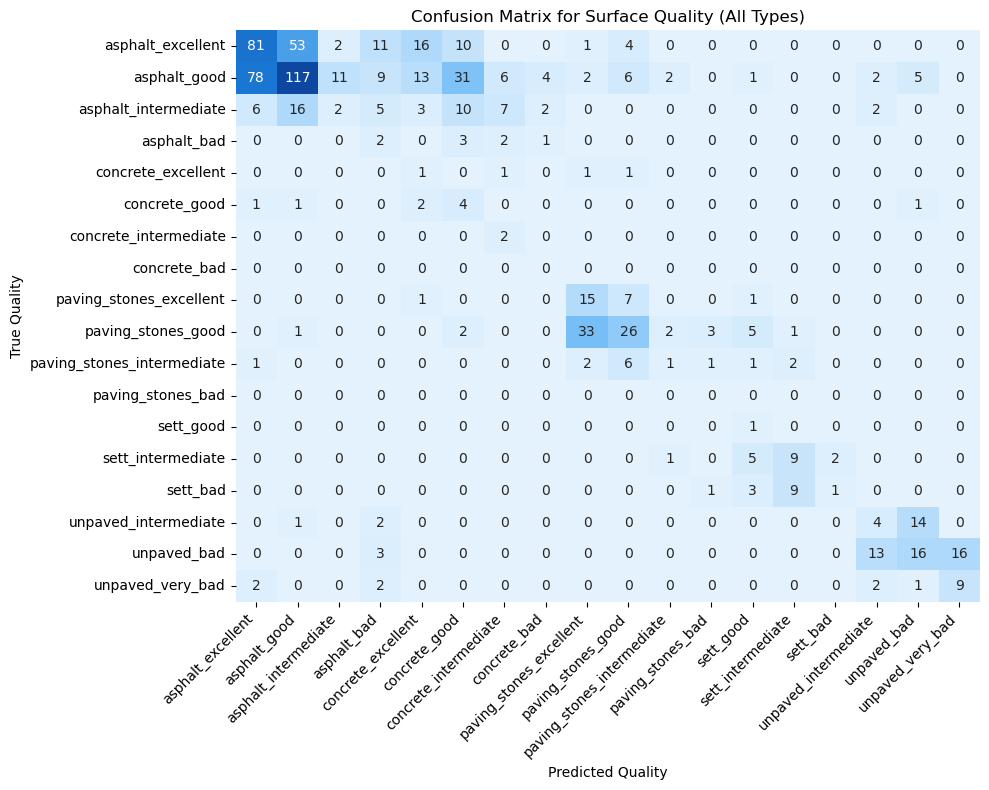

Overall confusion matrix plot saved at: C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\confusion_matrix_fine_hierarchical-Condition_CNN-corn-use_ground_truth-withlw_20241130_114238-mn14rraf42_epoch3.pt-corn-__corntest.png


In [441]:
# Custom blue colormap
blue_cmap = LinearSegmentedColormap.from_list("blue_cmap", ["#E3F2FD", "#64B5F6", "#1976D2", "#0D47A1"])

# Define all 18 class labels
class_labels = [
    "asphalt_excellent", "asphalt_good", "asphalt_intermediate", "asphalt_bad",
    "concrete_excellent", "concrete_good", "concrete_intermediate", "concrete_bad",
    "paving_stones_excellent", "paving_stones_good", "paving_stones_intermediate", "paving_stones_bad",
    "sett_good", "sett_intermediate", "sett_bad",
    "unpaved_intermediate", "unpaved_bad", "unpaved_very_bad"
]

# Overall confusion matrix
cm = confusion_matrix(merged_df.fine_true_int, merged_df.fine_prediction_int, labels=range(len(class_labels)))

# Plot the overall confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap=blue_cmap, cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for Surface Quality (All Types)")
plt.xlabel("Predicted Quality")
plt.ylabel("True Quality")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the overall confusion matrix
if "train" in base_file and only_validation:
    overall_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_fine_{file_name}__{head}validation.png")
elif "train" in base_file and not only_validation:
    overall_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_fine_{file_name}__{head}train.png")
else:
    overall_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_fine_{file_name}__{head}test.png")

plt.savefig(overall_conf_matrix_file, transparent=True, bbox_inches='tight')
plt.show()

print(f"Overall confusion matrix plot saved at: {overall_conf_matrix_file}")

# Confusion matrix for each surface type
# for surface_type, group in df.groupby("type_true"):
#     # Calculate confusion matrix for this surface type
#     cm = confusion_matrix(group.fine_true, group.fine_prediction, labels=range(len(class_labels)))
    
#     # Plot the confusion matrix
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt="d", cmap=blue_cmap, cbar=False,
#                 xticklabels=class_labels, yticklabels=class_labels)
#     plt.title(f"Confusion Matrix for Surface Quality ({surface_type})")
#     plt.xlabel("Predicted Quality")
#     plt.ylabel("True Quality")
#     plt.xticks(rotation=45, ha="right")
#     plt.yticks(rotation=0)
#     plt.tight_layout()
    
#     # Save the plot with surface type in the filename
#     conf_matrix_file = os.path.join(results_path, f"confusion_matrix_{surface_type}_{base_file}.png")
#     plt.savefig(conf_matrix_file, transparent=True, bbox_inches='tight')
#     plt.show()
    
#     print(f"Confusion matrix for {surface_type} saved at: {conf_matrix_file}")

In [442]:
# Custom green colormap
# green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["#E8F5E9", "#81C784", "#388E3C", "#1B5E20"])

# # Define coarse class labels
# coarse_class_labels = ["asphalt", "concrete", "paving_stones", "sett", "unpaved"]

# # Compute the confusion matrix for the coarse prediction
# coarse_cm = confusion_matrix(
#     merged_df['type_true'], merged_df['type_prediction'], labels=coarse_class_labels
# )

# # Plot the coarse confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(coarse_cm, annot=True, fmt="d", cmap=green_cmap, cbar=False,
#             xticklabels=coarse_class_labels, yticklabels=coarse_class_labels)
# plt.title("Confusion Matrix for Surface Type (Coarse Prediction)")
# plt.xlabel("Predicted Type")
# plt.ylabel("True Type")
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()

# # Save the coarse confusion matrix
# if "train" in base_file and only_validation:
#     coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_validation.png")
# elif "train" in base_file and not only_validation:
#     coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_train.png")
# else:
#     coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_test.png")

# plt.savefig(coarse_conf_matrix_file, transparent=True, bbox_inches='tight')
# plt.show()

# print(f"Coarse confusion matrix plot saved at: {coarse_conf_matrix_file}")

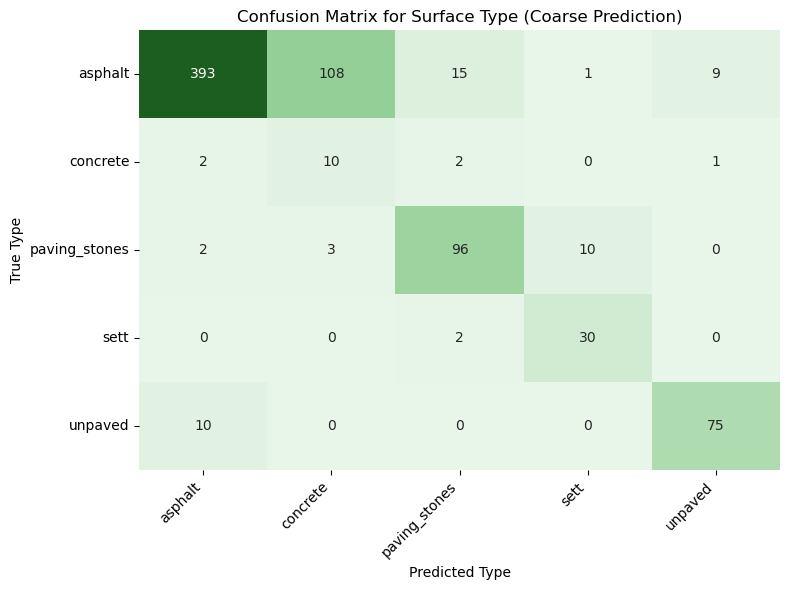

Coarse confusion matrix plot saved at: C:\Users\esthe\Documents\GitHub\classification_models\data\training\prediction\Esther_MA\results_metrics\confusion_matrix_coarse_hierarchical-Condition_CNN-corn-use_ground_truth-withlw_20241130_114238-mn14rraf42_epoch3.pt-corn-_corn_test.png


In [443]:
# Custom green colormap
green_cmap = LinearSegmentedColormap.from_list("green_cmap", ["#E8F5E9", "#81C784", "#388E3C", "#1B5E20"])

# Define coarse class labels
coarse_class_labels = ["asphalt", "concrete", "paving_stones", "sett", "unpaved"]

# Compute the confusion matrix for the coarse prediction
coarse_cm = confusion_matrix(
    merged_df['type_true'], merged_df['type_prediction'], labels=coarse_class_labels
)
# coarse_cm = confusion_matrix(
#     merged_df['quality_label_true'], merged_df['fine_prediction'], labels=coarse_class_labels
# )

# Plot the coarse confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(coarse_cm, annot=True, fmt="d", cmap=green_cmap, cbar=False,
            xticklabels=coarse_class_labels, yticklabels=coarse_class_labels)
plt.title("Confusion Matrix for Surface Type (Coarse Prediction)")
plt.xlabel("Predicted Type")
plt.ylabel("True Type")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# Save the coarse confusion matrix
if "train" in base_file and only_validation:
    coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_{head}_validation.png")
elif "train" in base_file and not only_validation:
    coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_{head}_train.png")
else:
    coarse_conf_matrix_file = os.path.join(results_path, f"confusion_matrix_coarse_{file_name}_{head}_test.png")

plt.savefig(coarse_conf_matrix_file, transparent=True, bbox_inches='tight')
plt.show()

print(f"Coarse confusion matrix plot saved at: {coarse_conf_matrix_file}")

In [444]:
merged_df['type_prediction'], merged_df['type_true_int']

(0      unpaved
 1      asphalt
 2      asphalt
 3      asphalt
 4         sett
         ...   
 764    asphalt
 765       sett
 766    unpaved
 767    unpaved
 768    asphalt
 Name: type_prediction, Length: 769, dtype: object,
 0      4
 1      2
 2      0
 3      0
 4      3
       ..
 764    0
 765    3
 766    4
 767    4
 768    0
 Name: type_true_int, Length: 769, dtype: int64)

In [445]:
# cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

# # Define all 18 class labels
# class_labels = [
#     "asphalt_excellent", "asphalt_good", "asphalt_intermediate", "asphalt_bad",
#     "concrete_excellent", "concrete_good", "concrete_intermediate", "concrete_bad",
#     "paving_stones_excellent", "paving_stones_good", "paving_stones_intermediate", "paving_stones_bad",
#     "sett_good", "sett_intermediate", "sett_bad",
#     "unpaved_intermediate", "unpaved_bad", "unpaved_very_bad"
# ]

# # Calculate the confusion matrix with all classes
# cm = confusion_matrix(df.fine_true, df.fine_prediction, labels=range(len(class_labels)))

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
#             xticklabels=class_labels, yticklabels=class_labels)
# plt.title("Confusion Matrix for Surface Quality (All Types)")
# plt.xlabel("Predicted Quality")
# plt.ylabel("True Quality")
# plt.xticks(rotation=45, ha="right")
# plt.yticks(rotation=0)
# plt.tight_layout()

# # Save the plot to the same directory as results_df
# conf_matrix_file = os.path.join(results_path, f"confusion_matrix_{pred_file}.png")
# plt.savefig(conf_matrix_file, transparent=True, bbox_inches='tight')
# plt.show()

# print(f"Confusion matrix plot saved at: {conf_matrix_file}")